In [1]:
from osgeo import gdal, gdalconst, gdal_array
from PIL import Image
import pylab as plt
import matplotlib.image as mpimg
import csv
import numpy as np
import geopandas as gpd
from sklearn.model_selection import KFold 
from sklearn import cross_validation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
import pandas as pd
from sklearn.metrics import roc_auc_score
from scipy import ndimage
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

/nfshome/gb1877/.conda/envs/gbVE/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Create training image

In [2]:
# Read in Houston training image

resampled_input = 'data/houston/h_train_ts2.tif'

houston_read = gdal.Open(resampled_input, gdal.GA_ReadOnly)

h_train = np.zeros((houston_read.RasterYSize, houston_read.RasterXSize),
               gdal_array.GDALTypeCodeToNumericTypeCode(houston_read.GetRasterBand(1).DataType))
h_train = houston_read.ReadAsArray()
h_train.shape

(2100, 2528)

In [3]:
# Reclass the pixels in our new categories

h_train = np.nan_to_num(h_train)

category_dict = {0:4, 1:1, 2:2, 3:2, 4:3, 5:3, 6:4, 7:4, 8:4, 9:4, 10:4, 255:4}

h_train_cat = np.vectorize(category_dict.get)(h_train.reshape(-1,1))

# Reshape the categorized image to its proper x,y shape
h_train_cat=h_train_cat.reshape(h_train.shape)
print(h_train_cat.shape)

(2100, 2528)


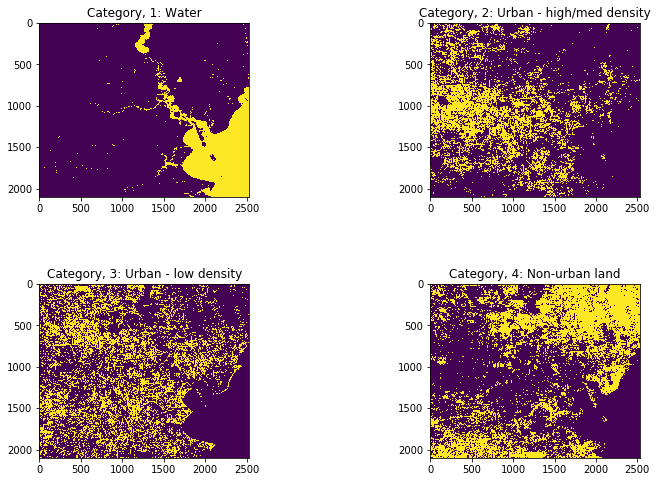

In [4]:
# Show training image
fig, axs = plt.subplots(2,2, figsize=(14, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()
titles=['1: Water','2: Urban - high/med density','3: Urban - low density',
      '4: Non-urban land']

for i in range(4):
    axs[i].imshow(h_train_cat==i+1)
    axs[i].set_title("Category, "+titles[i])

# Load in satellite images

In [5]:
inputfile99 = 'data/houston/H_small_1999.tif'
dataset99 = gdal.Open(inputfile99, gdal.GA_ReadOnly)

inputfile07 = 'data/houston/H_small_2007.tif'
dataset07 = gdal.Open(inputfile07, gdal.GA_ReadOnly)

inputfile15 = 'data/houston/H_small_2015.tif'
dataset15 = gdal.Open(inputfile15, gdal.GA_ReadOnly)

In [6]:
# Load them into arrays

# 1999
image99 = np.zeros((dataset99.RasterYSize, dataset99.RasterXSize, dataset99.RasterCount))
image_datatype = dataset99.GetRasterBand(1).DataType
image99 = np.zeros((dataset99.RasterYSize, dataset99.RasterXSize, dataset99.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
for b in range(dataset99.RasterCount):
    band = dataset99.GetRasterBand(b + 1)
    image99[:, :, b] = band.ReadAsArray()

In [7]:
# 2007
image07 = np.zeros((dataset07.RasterYSize, dataset07.RasterXSize, dataset07.RasterCount))
image_datatype = dataset07.GetRasterBand(1).DataType
image07 = np.zeros((dataset07.RasterYSize, dataset07.RasterXSize, dataset07.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
for b in range(dataset07.RasterCount):
    band = dataset07.GetRasterBand(b + 1)
    image07[:, :, b] = band.ReadAsArray()

In [8]:
# 2015
image15 = np.zeros((dataset15.RasterYSize, dataset15.RasterXSize, dataset15.RasterCount))
image_datatype = dataset15.GetRasterBand(1).DataType
image15 = np.zeros((dataset15.RasterYSize, dataset15.RasterXSize, dataset15.RasterCount),
                 dtype=gdal_array.GDALTypeCodeToNumericTypeCode(image_datatype))
for b in range(dataset15.RasterCount):
    band = dataset15.GetRasterBand(b + 1)
    image15[:, :, b] = band.ReadAsArray()

In [9]:
image99 = np.nan_to_num(image99)
image07 = np.nan_to_num(image07)
image15 = np.nan_to_num(image15)

Band 4 of the satellite image: east-central Houston


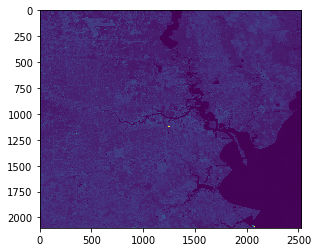

In [10]:
plt.imshow(image99[:,:,4])
print("Band 4 of the satellite image: east-central Houston")

In [11]:
print('satellite99: ',image99.shape)
print('satellite07: ',image07.shape)
print('satellite15: ',image15.shape)
print("train: ",h_train_cat.shape)


satellite99:  (2100, 2528, 11)
satellite07:  (2100, 2528, 11)
satellite15:  (2100, 2528, 11)
train:  (2100, 2528)


In [12]:
#Check files are different
print(np.unique(image99[:1000,:1000,0],return_counts=True))
print(np.unique(image15[:1000,:1000,0],return_counts=True))

(array([0.     , 0.0198 , 0.0199 , ..., 1.23005, 1.2661 , 2.     ],
      dtype=float32), array([973,   1,   4, ...,   2,   1,  62]))
(array([-0.0681 ,  0.     ,  0.0193 , ...,  1.26665,  1.2709 ,  2.     ],
      dtype=float32), array([   1,  808,    3, ...,    1,    1, 1369]))


# Train random forest on 2015 image

In [13]:
#filtered_train = ndimage.gaussian_filter(h_train_cat, sigma=5)
#image15[:, :, 10] = filtered_train

In [16]:
# Create flattened X and y arrays
new_shape = (image15.shape[0] * image15.shape[1],9)
#new_shape_15 = (image15.shape[0] * image15.shape[1],10)
X99 = image99[:, :, :9].reshape(new_shape)
X07 = image07[:, :, :9].reshape(new_shape)
X15 = image15[:, :, :9].reshape(new_shape)

Y = h_train_cat.reshape(-1,1).ravel()
print("Check shapes match: ",X99.shape, X15.shape,X07.shape,Y.shape)
#print(X15.shape, Y.shape)

Check shapes match:  (5308800, 9) (5308800, 9) (5308800, 9) (5308800,)


In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
# your code here 
from sklearn.model_selection import GridSearchCV
param_grid ={'n_estimators':range(3,15)}
rf =  RandomForestClassifier(random_state=99)
gr=GridSearchCV(rf,param_grid=param_grid)
rf=gr.fit(X15,Y)
print (rf.best_params_)
print (accuracy_score(np.array(Y),rf.predict(X15)))

KeyboardInterrupt: 

In [22]:
# Train RF from 2015 Landsat and training image

rf = RandomForestClassifier(n_estimators=8)
rf = rf.fit(X15, Y.ravel())


In [29]:
# Predict classes for each year
#pred_99 = rf.predict(X99)
#pred_07 = rf.predict(X07)
pred_15 = rf.predict(X15)

# Reshape outputs to matrix form
#pred_99 = pred_99.reshape(image15[:, :, 0].shape)
#pred_07 = pred_07.reshape(image15[:, :, 0].shape)
pred_15 = pred_15.reshape(image15[:, :, 0].shape)

In [46]:
print (accuracy_score(np.array(Y.ravel()),rf.predict(X15)))

0.9797830018083182


In [38]:
for i in range(12,15):
    from sklearn.model_selection import cross_val_score
    from sklearn import metrics
    rf = RandomForestClassifier(n_estimators=i)
    scores = cross_val_score(rf, X15, Y.ravel(), cv=5, scoring='f1_macro')
    lis_score.append(scores.mean())

KeyboardInterrupt: 

In [24]:
## For estimators=7
scores.mean()

0.7527992326852028

In [25]:
lis_score = [0.7508,0.7527 ]

In [39]:
lis_score

[0.7508,
 0.7527,
 0.7553245484421334,
 0.757311850407429,
 0.7586630139843621,
 0.7596145703664747,
 0.7607250399853347]

In [40]:
est = [7,8,9,10,11,12,13]

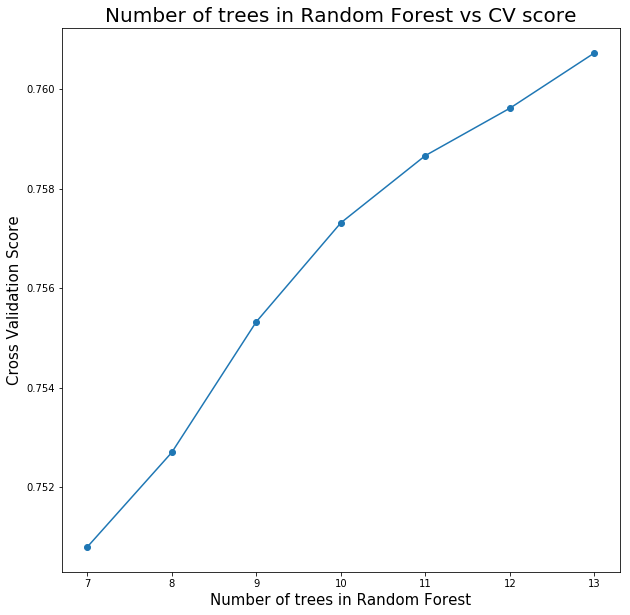

In [45]:
plt.figure(figsize=(10,10))
plt.plot(est,lis_score,  'o-')
plt.title('Number of trees in Random Forest vs CV score', fontsize=20)
plt.xlabel('Number of trees in Random Forest', fontsize=15)
plt.ylabel('Cross Validation Score',fontsize=15);

In [34]:
figs = [pred_99,pred_07,pred_15]
len(figs)

NameError: name 'pred_99' is not defined

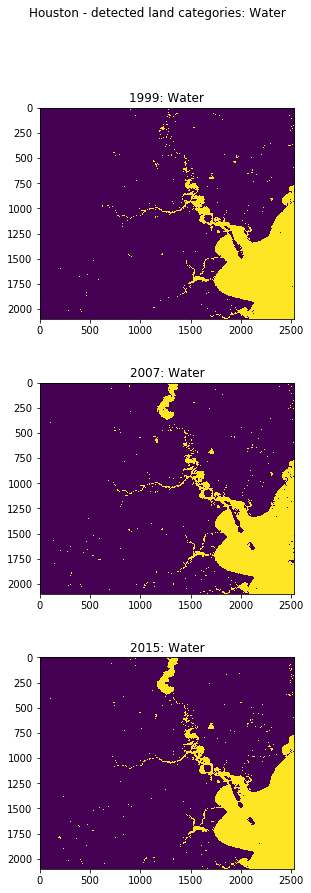

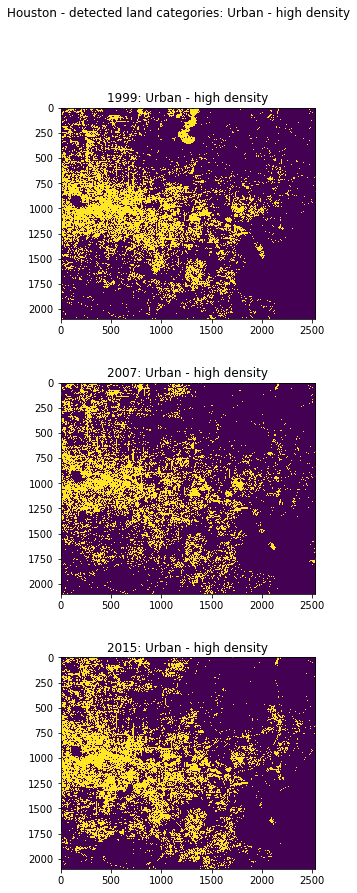

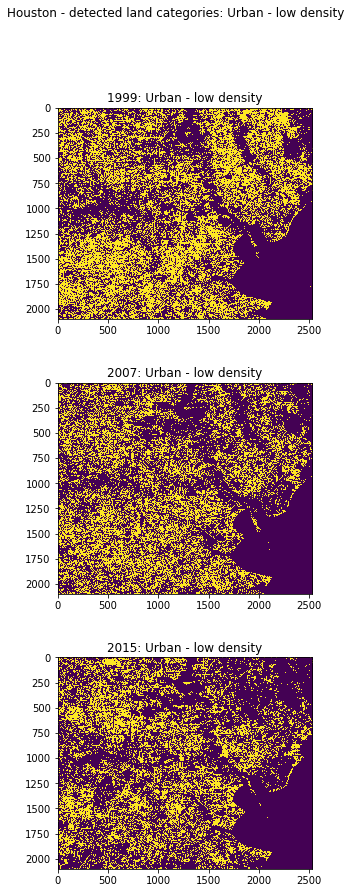

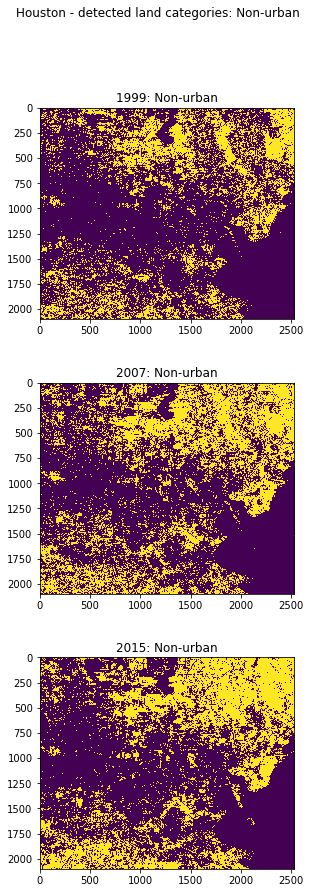

In [71]:
cats = ['Water','Urban - high density','Urban - low density','Non-urban']
cat_labels = [1,2,3,4]

for i in range(1,5):

    fig, axs = plt.subplots(3,1, figsize=(10, 14), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .3, wspace=.001)

    axs = axs.ravel()

    figs = [pred_99,pred_07,pred_15]
    titles = ['1999','2007','2015']

    for j in range (len(figs)):
        axs[j].imshow(figs[j] == i)
        axs[j].set_title(titles[j]+": "+cats[i-1])

    fig.suptitle("Houston - detected land categories: "+cats[i-1])

# Evaluate the model with 6-fold cross-validation
Testing the 2015 predictions against the testing image (also 2015)

In [ ]:
kfold = KFold(n_splits = 6)

rf = RandomForestClassifier(n_estimators=12)
scores = cross_val_score(rf, X15, Y, cv = kfold)
print("Cross validation scores {}".format(scores))
print("Mean cross validation score {}".format(scores.mean()))

/nfshome/nj935/.conda/envs/remote_sensing/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


# Tune up Random Forest with gridsearch